In [1]:
from __future__ import print_function
import os
import sys
import urllib
import pandas as pd
import matplotlib.pylab as plt
import fiona
import geopandas
%pylab inline
import requests
import json
import io
import shapely
import pysal as ps
from pysal.contrib.viz import mapping as maps
from geopandas import GeoDataFrame
from shapely.geometry import Point

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 1. PUMA : Public Use Microdata Area¶

## 1.1 download the NYC Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas

In [2]:
x = os.getenv('PUIDATA')
x

'/nfshome/vvt221/PUIdata'

In [3]:
url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'
urllib.request.urlretrieve(url, "puma.zip")

os.system("unzip " "puma.zip" + " -d " + os.getenv('PUIDATA') + '/puma')
for filename in os.listdir(os.getenv('PUIDATA') + '/puma'):
    if filename.endswith('.shp'):
        os.rename(os.getenv('PUIDATA') + '/puma/' + filename, os.getenv('PUIDATA') + '/puma/' + 'puma.shp')
    if filename.endswith('.dbf'):
        os.rename(os.getenv('PUIDATA') + '/puma/' + filename, os.getenv('PUIDATA') + '/puma/' + 'puma.dbf')
    if filename.endswith('.prj'):
        os.rename(os.getenv('PUIDATA') + '/puma/' + filename, os.getenv('PUIDATA') + '/puma/' + 'puma.prj')
    if filename.endswith('.shx'):
        os.rename(os.getenv('PUIDATA') + '/puma/' + filename, os.getenv('PUIDATA') + '/puma/' + 'puma.shx')

In [4]:
puma_shape_file = geopandas.GeoDataFrame.from_file('%s/puma/puma.shp'%os.getenv('PUIDATA'))



In [5]:
puma_shape_file.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [6]:
puma_shape_file.crs

{'init': 'epsg:4326'}

In [7]:
puma_shape_file.shape

(55, 4)

## 1.2 plot the PUMA NYC regions

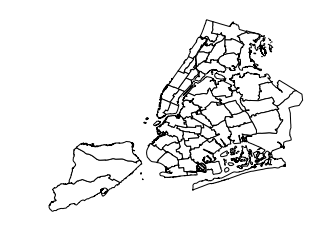

In [8]:
puma_nyc_regions = puma_shape_file.plot(color='white', edgecolor='black' , figsize=(5,5))
puma_nyc_regions.set_axis_off()

#### FIG 1: Plot of the PUMA regions in NYC

# 2. American Fact Finder data on percentage of houses with broadband internet access

## 2.1 Get data with American Fact Finder (AFF) API:

In [9]:
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)
aff1y

{'variables': {'B24123_085E': {'attributes': 'B24123_085M,B24123_085EA',
   'concept': 'DETAILED OCCUPATION BY MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS) FOR THE FULL-TIME, YEAR-ROUND CIVILIAN EMPLOYED FEMALE POPULATION 16 YEARS AND OVER',
   'group': 'B24123',
   'label': 'Estimate!!Total!!Environmental engineers',
   'limit': 0,
   'predicateType': 'int'},
  'B27001H_019E': {'attributes': 'B27001H_019M,B27001H_019EA',
   'concept': 'HEALTH INSURANCE COVERAGE STATUS BY AGE (WHITE ALONE, NOT HISPANIC OR LATINO)',
   'group': 'B27001H',
   'label': 'Estimate!!Total!!45 to 54 years!!No health insurance coverage',
   'limit': 0,
   'predicateType': 'int'},
  'B27001F_024E': {'attributes': 'B27001F_024M,B27001F_024EA',
   'concept': 'HEALTH INSURANCE COVERAGE STATUS BY AGE (SOME OTHER RACE ALONE)',
   'group': 'B27001F',
   'label': 'Estimate!!Total!!65 to 74 years!!With health insurance coverage',
   'limit': 0,
   'predicateType': 'int'},
  'B20005D_042E':

In [10]:
affkeys = np.array(list(aff1y['variables'].keys()))
affkeys

array(['B24123_085E', 'B27001H_019E', 'B27001F_024E', ..., 'B22010_002E',
       'C08534_004E', 'C08113_022E'], 
      dtype='<U14')

In [11]:
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription')]

In [12]:
#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

In [13]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36"
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [14]:
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B11001A") and 
 'household' in aff1y['variables'][k]['label']]

[('B11001A_007E', 'Estimate!!Total!!Nonfamily households'),
 ('B11001A_008E',
  'Estimate!!Total!!Nonfamily households!!Householder living alone'),
 ('B11001A_003E', 'Estimate!!Total!!Family households!!Married-couple family'),
 ('B11001A_002E', 'Estimate!!Total!!Family households'),
 ('B11001A_004E', 'Estimate!!Total!!Family households!!Other family'),
 ('B11001A_006E',
  'Estimate!!Total!!Family households!!Other family!!Female householder, no husband present'),
 ('B11001A_009E',
  'Estimate!!Total!!Nonfamily households!!Householder not living alone'),
 ('B11001A_005E',
  'Estimate!!Total!!Family households!!Other family!!Male householder, no wife present')]

In [15]:
#keyword for the number of households with broarband access
keyNBB = 'B11001A_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B11001A_004M,B11001A_004EA',
 'concept': 'HOUSEHOLD TYPE (INCLUDING LIVING ALONE) (WHITE ALONE)',
 'group': 'B11001A',
 'label': 'Estimate!!Total!!Family households!!Other family',
 'limit': 0,
 'predicateType': 'int'}

In [16]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [17]:

url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36"
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))



In [18]:
pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN



## 2.2 generate a feature for the percentage of households with broadband access

In [19]:
pumaPP['NAME'] = pumaPP['NAME'].astype(str)
pumaBB['NAME'] = pumaBB['NAME'].astype(str)

In [20]:
PPBB = pd.merge(pumaPP , pumaBB, how='left', on='NAME')
PPBB

,B28002_001E,NAME,state_x,public use microdata area_x,Unnamed: 4_x,B28002_004E,state_y,public use microdata area_y,Unnamed: 4_y
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN,32607,36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,50811,36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN,41210,36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,36075,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,47786,36,402,NaN
5,42081,"Otsego, Schoharie, Oneida (South) & Herkimer (...",36,403,NaN,32221,36,403,NaN
6,50860,"Jefferson & Lewis Counties PUMA, New York",36,500,NaN,41386,36,500,NaN
7,44633,"Oswego County PUMA, New York",36,600,NaN,37692,36,600,NaN
8,56295,"Onondaga County (Central)--Syracuse City PUMA,...",36,701,NaN,37719,36,701,NaN
9,47988,"Onondaga County (North) PUMA, New York",36,702,NaN,40309,36,702,NaN


In [21]:
PPBB['percentage'] = (PPBB['B28002_004E'] / PPBB['B28002_001E'] *100)
PPBB.head()

,B28002_001E,NAME,state_x,public use microdata area_x,Unnamed: 4_x,B28002_004E,state_y,public use microdata area_y,Unnamed: 4_y,percentage
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN,32607,36,100,NaN,80.552879
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,50811,36,200,NaN,75.733321
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN,41210,36,300,NaN,79.842678
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,36075,36,401,NaN,81.433409
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,47786,36,402,NaN,78.150656


## 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

In [22]:
bbpc = pd.read_csv(os.getenv('PUIDATA') + '/ACS_16_1YR_GCT2801.ST50_with_ann.csv',usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8


In [23]:
bbpc.drop(0, inplace=True)
bbpc['GCT_STUB.target-geo-id2'] = bbpc['GCT_STUB.target-geo-id2'].astype(int)


In [24]:
bbpc.dtypes

GCT_STUB.target-geo-id2     int64
HC01                       object
HC02                       object
dtype: object

In [25]:
bbpc['gid'] = bbpc['GCT_STUB.target-geo-id2'] - 3600000
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02,gid
1,1,74.7,0.5,-3599999
2,100100,70.9,2.5,-3499900
3,100200,80.5,2.7,-3499800
4,100301,87.0,2.8,-3499699
5,100302,81.9,2.9,-3499698


## check that the percentage of households with broadband you generated and the one you red in from the table you downloaded manually are the same

In [26]:
diff = PPBB.merge( bbpc, right_on='gid' ,left_on='public use microdata area_x')[['percentage','HC01','gid']]
diff.head()

,percentage,HC01,gid
0,80.552879,80.6,100
1,75.733321,75.7,200
2,79.842678,79.8,300
3,81.433409,81.4,401
4,78.150656,78.2,402


In [27]:
diff['difference'] = np.abs(diff['HC01'].astype(float) - diff['percentage'])
#diff[['difference']]

In [28]:
diff.HC01 = diff.HC01.astype(float)

In [29]:
diff.describe()

,percentage,HC01,gid,difference
count,145.000000,145.000000,145.000000,145.000000
mean,81.845478,81.843448,2826.827586,0.026217
std,7.063369,7.065358,1210.054822,0.014480
min,54.932945,54.900000,100.000000,0.000178
25%,77.770257,77.800000,1900.000000,0.012252
50%,82.826141,82.800000,3208.000000,0.027230
75%,87.305077,87.300000,3809.000000,0.039090
max,93.404143,93.400000,4114.000000,0.049872


In [30]:
diff.columns

Index(['percentage', 'HC01', 'gid', 'difference'], dtype='object')

In [31]:
diff['puma'] = diff['gid']
diff[diff['puma'] > 3000]

,percentage,HC01,gid,difference,puma
55,88.835665,88.8,3001,0.035665,3001
56,83.909505,83.9,3002,0.009505,3002
57,61.844466,61.8,3003,0.044466,3003
58,93.404143,93.4,3101,0.004143,3101
59,85.477072,85.5,3102,0.022928,3102
60,90.106612,90.1,3103,0.006612,3103
61,88.875710,88.9,3104,0.024290,3104
62,92.251900,92.3,3105,0.048100,3105
63,80.127707,80.1,3106,0.027707,3106
64,81.716747,81.7,3107,0.016747,3107


In [32]:
diff.puma = diff.puma.astype(str)
diff.dtypes

percentage    float64
HC01          float64
gid             int64
difference    float64
puma           object
dtype: object

# 3 Plot a choropleth of NYC broadband access

## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [33]:
#choropleth of the percentage of internet axcess

# 1. perform join on the puma shape file and the percentage data frame
puma_shape_file1 = puma_shape_file.merge(diff,how='inner',on='puma')

In [34]:
puma_shape_file1.head()

,puma,shape_area,shape_leng,geometry,percentage,HC01,gid,difference
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,84.275820,84.3,3701,0.024180
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",68.310015,68.3,3702,0.010015
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,82.826141,82.8,3703,0.026141
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",72.553737,72.6,3704,0.046263
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,78.778618,78.8,4015,0.021382


(-74.283370477424782,
 -73.672229948940085,
 40.47514452607718,
 40.936503646096469)

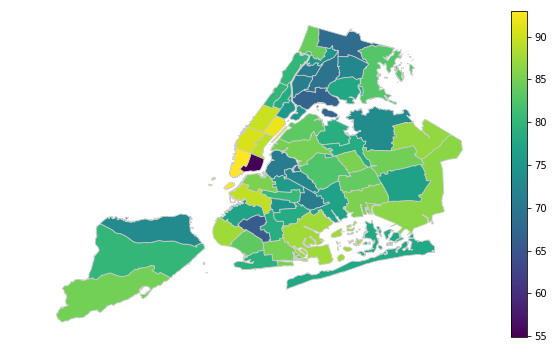

In [35]:
variable ='percentage of households with broadband access'

fig, ax = plt.subplots(1, figsize=(10,6))

puma_shape_file1.plot(column='percentage',cmap='viridis',linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,k=10)
ax.axis('off')


#### Fig 2: Chlorpleth of NYC displaying percentage of households having broadband access per PUMA

# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

In [36]:
os.environ["PUI2018"] = "%s/PUI2018"%os.getenv("HOME")


In [37]:
linkNYC =pd.read_csv(os.getenv('PUI2018') + '/PUI2018_fb55/HW7_fb55/linkNYClocations.csv',usecols=['link_site','longitude','date_link_','latitude'])
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [38]:
linkNYC.shape

(1414, 4)

# combine long lat into a column like you did in the lab to greate a "geometry" column for the dataframe, then convert the dataframe into a GeoDataFrame linkNYC and set native coordinates frame to lat/lon as you did in the lab¶

In [39]:
linkNYC['lonlat'] = list(zip(linkNYC.longitude , linkNYC.latitude))
linkNYC['geometry'] = linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [40]:
linkNYC_sort = linkNYC.sort_values(by= 'date_link_', axis=0, ascending=True)

linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


# plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in 5 equal intervals

In [41]:
linkNYC_sort['geometry'].dtypes

dtype('O')

In [42]:


geometry = [Point(xy) for xy in zip(linkNYC_sort.longitude, linkNYC_sort.latitude)]
linkNYC_gdf = linkNYC_sort.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}
linkNYC_gdf = GeoDataFrame(linkNYC_sort, crs=crs, geometry=geometry)


In [43]:
linkNYC_gdf.dtypes

link_site      object
longitude     float64
date_link_     object
latitude      float64
lonlat         object
geometry       object
dtype: object

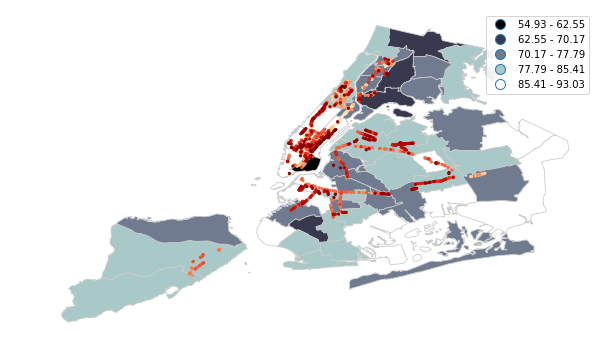

In [44]:
variable ='percentage of households with broadband access'

fig, ax = plt.subplots(1, figsize=(10,6))

puma_shape_file1.plot(column='percentage',cmap='bone',linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, scheme = 'Equal_interval', k = 5)
ax.axis('off')

linkNYC_gdf.plot(column='date_link_',ax=ax, markersize=5,cmap='OrRd')

#### Fig 3 : Chlorpleth of NYC displaying percentage of households having broadband access per PUMA in terms of 5 percentage levels. The figure also displays the location of the linkNYC stations on top of the choropleth 

# 5 Find the number of linkNYC locations per person by PUMA


## 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

the ACS population by variable is B00001_001E, and of course your geometry is PUMA, public%20use%20microdata%20area:*, as before

In [45]:
url = "https://api.census.gov/data/2016/acs/acs1?get=B00001_001E" +  \
",NAME&for=public%20use%20microdata%20area:*&in=state:36"
resp = requests.request('GET', url).content
pumapop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))


pumapop['public use microdata area'] = pumapop['public use microdata area'].astype(str)
puma_shape_file['puma'] = puma_shape_file['puma'].astype(str)
pumaPP.dtypes

B28002_001E                    int64
NAME                          object
state                          int64
public use microdata area      int64
Unnamed: 4                   float64
dtype: object

In [46]:
puma_shape_file.dtypes

puma           object
shape_area    float64
shape_leng    float64
geometry       object
dtype: object

In [47]:
pumapop_population = pumapop[['public use microdata area', 'B00001_001E']]
pumapop_population.dtypes

public use microdata area    object
B00001_001E                   int64
dtype: object

In [48]:
merge_PP_linkNYC = puma_shape_file.merge(pumapop_population , right_on='public use microdata area' ,left_on='puma')

In [49]:
merge_PP_linkNYC

,puma,shape_area,shape_leng,geometry,public use microdata area,B00001_001E
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,3701,1517
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",3702,1959
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,3703,1305
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",3704,1882
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,4015,2515
5,4016,1.207135e+08,109477.751817,POLYGON ((-73.94405560932151 40.61199284173428...,4016,2926
6,3705,1.224951e+08,68657.316149,POLYGON ((-73.87359713633828 40.83979855593596...,3705,2011
7,3706,4.388687e+07,51799.404183,"POLYGON ((-73.88785196328796 40.8721141761279,...",3706,1274
8,3707,4.228113e+07,37347.925798,"POLYGON ((-73.89735765412577 40.8587627349268,...",3707,1548
9,4006,6.184965e+07,42555.996557,POLYGON ((-73.95526963654763 40.67012490485409...,4006,1846


## 5.2 find the number of station per 100 people per PUMA

### convert both pumashp and linkNYC to 2263 (for example with GeoDataFrame method .to_crs(epsg=...) )

In [50]:
crs = {'init': 'epsg:2263'}
linkNYC_convert = GeoDataFrame(linkNYC_gdf, crs=crs)

In [51]:
crs = {'init': 'epsg:2263'}
linkNYC_PP_convert = GeoDataFrame(merge_PP_linkNYC, crs=crs)

### create a geodataframe with a spatial join and use groupby to count the number of linkNYC in each PUMA

In [52]:
linkpp = geopandas.sjoin(linkNYC_PP_convert,linkNYC_convert).groupby(by=['puma']).count()


In [53]:
link_nyc_counts = linkpp[['link_site']]
link_nyc_counts =link_nyc_counts.reset_index()
link_nyc_counts.head()

,puma,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


In [54]:
puma_shape_file_linknyc = merge_PP_linkNYC.merge(link_nyc_counts,on='puma',how='outer')

In [55]:
puma_shape_file_linknyc

,puma,shape_area,shape_leng,geometry,public use microdata area,B00001_001E,link_site
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,3701,1517,1.0
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",3702,1959,NaN
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,3703,1305,NaN
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",3704,1882,NaN
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,4015,2515,3.0
5,4016,1.207135e+08,109477.751817,POLYGON ((-73.94405560932151 40.61199284173428...,4016,2926,NaN
6,3705,1.224951e+08,68657.316149,POLYGON ((-73.87359713633828 40.83979855593596...,3705,2011,1.0
7,3706,4.388687e+07,51799.404183,"POLYGON ((-73.88785196328796 40.8721141761279,...",3706,1274,20.0
8,3707,4.228113e+07,37347.925798,"POLYGON ((-73.89735765412577 40.8587627349268,...",3707,1548,29.0
9,4006,6.184965e+07,42555.996557,POLYGON ((-73.95526963654763 40.67012490485409...,4006,1846,33.0


In [56]:
puma_shape_file_linknyc['wifiper100'] = puma_shape_file_linknyc['link_site'] * 100 / puma_shape_file_linknyc['B00001_001E']  
puma_shape_file_linknyc['wifiper100'].describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: wifiper100, dtype: float64

In [57]:
puma_shape_file_linknyc['linkNYCpp'] = puma_shape_file_linknyc['link_site'] / puma_shape_file_linknyc['B00001_001E']  
puma_shape_file_linknyc['linkNYCpp'].describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      0.023277
std       0.033290
min       0.000497
25%            NaN
50%            NaN
75%            NaN
max       0.151415
Name: linkNYCpp, dtype: float64

# at last, plot the linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


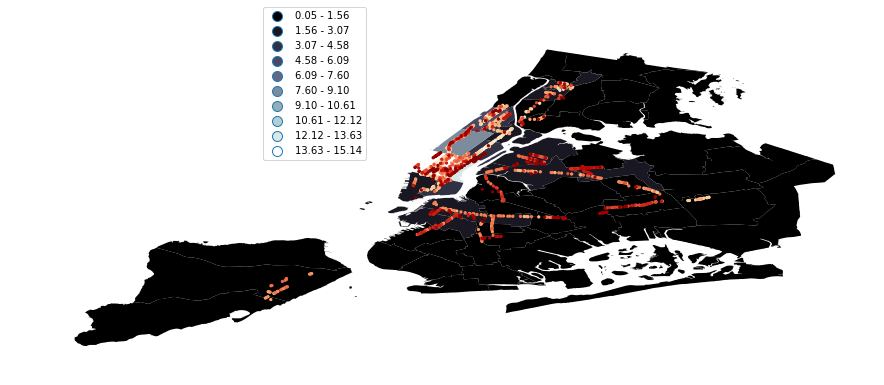

In [58]:
fig, ax = plt.subplots(1 , figsize=(15,6))
puma_shape_file_linknyc.plot(column='wifiper100', cmap='bone',ax=ax,legend=True, k=10, scheme='Equal_interval',linewidth=0.8,)
ax.set_axis_off()
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.2, 0.3, 0.2, 0.8))
linkNYC_gdf.plot(ax=ax, markersize=5,cmap='OrRd')

#### Fig 4: plot showing the linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals.

# Extra credit 1:


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


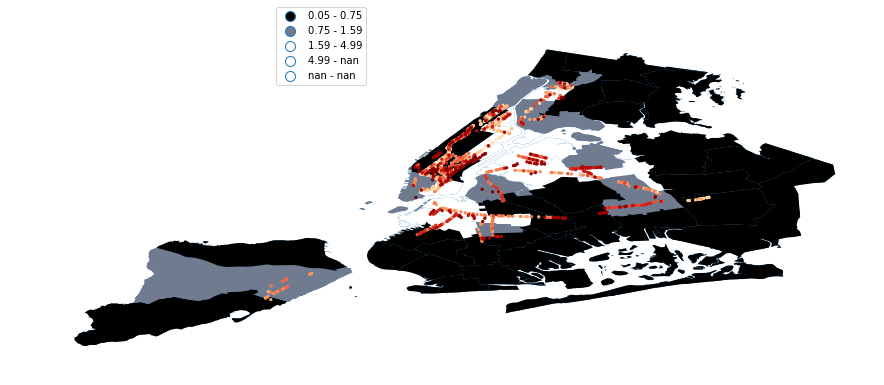

In [59]:
fig, ax = plt.subplots(1 , figsize=(15,6))
puma_shape_file.plot(ax=ax, )
puma_shape_file_linknyc.plot(column='wifiper100', cmap='bone',ax=ax,legend=True, k=5, scheme='Quantiles',linewidth=0.8)
ax.set_axis_off()
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.2, 0.3, 0.2, 0.8))
linkNYC_gdf.plot(ax=ax, markersize=5,cmap='OrRd')

#### Fig 5: plot showing the linkNYC locations on top of a choropleth of number of stations per 100 people in terms of the quantiles for greater visibility.

In [60]:
puma_shape_file_linknyc['wifiper100'].dropna(inplace=True)

Text(0,0.5,'Counts')

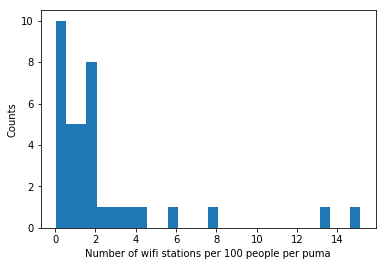

In [61]:
plt.hist(puma_shape_file_linknyc['wifiper100'] , bins=30)
plt.xlabel('Number of wifi stations per 100 people per puma')
plt.ylabel('Counts')

#### Fig 6 : Frequency distribution of the number of linkNYC per 100 people per puma

# Extra Credit 2:
plot Spatial Lag Deciles that describe the impact of linkNYC in providing access where needed. You can follow what you did in the lab, but you need to create a metric based on the data you have tha measures the impact of linkNYC


In [62]:

psfl = puma_shape_file_linknyc.dropna(subset=['wifiper100'])

In [63]:
psfl.to_file(os.getenv('PUIDATA') + '/psl.shp')

In [64]:
qW_CT=ps.queen_from_shapefile(os.getenv('PUIDATA') + '/psl.shp')

In [65]:
Wmatrix, ids = qW_CT.full()

In [66]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [67]:
qW_CT.transform = 'r'

In [68]:
lincNYC = psfl.wifiper100


In [69]:
lincNYCLag = ps.lag_spatial(qW_CT,lincNYC)

In [70]:
lincNYCLag

array([ 1.18138458,  0.95029009,  1.42273428,  0.69548539,  0.97305827,
        0.9737622 ,  0.95707177,  0.74448275,  2.96683175,  1.01317629,
        0.90709977,  4.43996932,  4.24333183,  5.50004562,  9.70407232,
        6.34510295,  6.06254163,  4.64638558,  6.52110505,  7.02772178,
        1.19274809,  0.18903592,  3.74180073,  0.62743201,  1.01297709,
        1.65105408,  1.12491327,  0.63674282,  0.5949582 ,  0.83861532,
        1.78700279,  1.77743444,  1.56884361,  1.52381242,  4.4007664 ,
        1.04584627,  1.28040973])

In [71]:
lincNYCLagQ10 = ps.Quantiles(lincNYCLag, k=10)
lincNYCLagQ10

              Quantiles              
 
Lower          Upper            Count
        x[i] <= 0.672               4
0.672 < x[i] <= 0.916               4
0.916 < x[i] <= 0.974               3
0.974 < x[i] <= 1.077               4
1.077 < x[i] <= 1.280               4
1.280 < x[i] <= 1.618               3
1.618 < x[i] <= 3.122               4
3.122 < x[i] <= 4.432               3
4.432 < x[i] <= 6.176               4
6.176 < x[i] <= 9.704               4

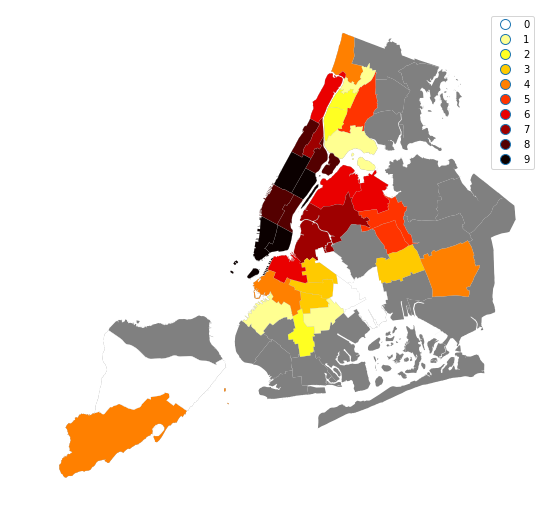

In [72]:

fig, ax = plt.subplots(1 , figsize=(9,9))
puma_shape_file.plot(color='grey',ax=ax)
#plt.subplots(figsize=(9, 9))
psfl.assign(cl=lincNYCLagQ10.yb).plot(ax=ax ,column='cl', categorical=True, 
      k=10, cmap='hot_r', linewidth=0.1, 
      edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("");

#### Fig 7 : Plot showing the spatial deciles of the linkNYC stations per 100 people per puma. The grey areas depict the puma with NaN values. The purpose of spatial lag is to eliminate any correlations that arise due to Tobler's law( There is spatial autocorrelation in a variable if observations that are closer to each other in space have related values) . The chlorpleth after spatial lag does show some correlation between certain PUMA's which are close to each other. But there are also certain adjacent PUMAs which have a vastly different linkNYC access proportions.